<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Writing metrics</b> <br>
Contact author: Eric Neilsen. ;l<br>
Questions welcome at <a href="https://community.lsst.org/c/sci/survey-strategy">community.lsst.org/c/sci/survey-strategy</a> and the <a href="https://lsstc.slack.com/archives/C2LTWTP5J">#sims_operations</a> slack channel.<br>
Find additional MAF documentation and resources at <a href="https://rubin-sim.lsst.io">rubin-sim.lsst.io</a>. <br>

**Credit:** Previous MAF tutorials, including not only the [tutorial notebooks in sims_MAF-contrib](https://github.com/LSST-nonproject/sims_maf_contrib/tree/master/tutorials) but also those by  Weixiang Yu, Gordon Richards, and Will Clarkson in their [LSST_OpSim](https://github.com/RichardsGroup/LSST_OpSim) repository, inspired the material to be included here. Stylistic elements of these notebooks were guided by the DP0.1 notebooks developed by Melissa Graham and the Rubin Observatory Community Engagement Team.

This notebook gives instructions on how to write `MAF` metrics, the most common code development task for science groups.

## 1. Notebook preparation

### 1.1 Developer aids

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505

### 1.2 Import the required python modules

In [3]:
import rubin_sim
from rubin_sim import maf

### 1.3 Get example data to work with

To test a metric, we will need to use a sample database. Let's use the sample baseline database installed as part of the `rubin_sim` installation process:

In [4]:
opsim_db_fname = rubin_sim.data.get_baseline()
opsim_db_fname

'/Users/lynnej/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db'

We will also need an output directory. If you have one you want to use, set it here:

In [5]:
# output_dir = '.'

Otherwise, create a temporary directory that will automatically be cleaned up when this notebook shuts down:

In [6]:
if "output_dir" not in locals():
    from tempfile import TemporaryDirectory
    import os

    output_dir_itself = TemporaryDirectory(prefix="writing_metrics_", dir=os.getcwd())
    output_dir = output_dir_itself.name

output_dir

'/Users/lynnej/lsst_repos/rubin_sim_notebooks/maf/tutorial/writing_metrics_ytz84q1g'

## 2. Understanding how metrics are called

To understand how to write metrics, it helps to first know a little bit about slicers.

`MAF` slicers categorize visits in the `opsim` database into groups called "slices." Slices have a "many to many" relationship with visits: a given slice may contain zero or more visits, and a given visit may fall into zero, one, or many slices. For example, the `HealpixSlicer` slices the sky according to [healpixels](https://healpix.jpl.nasa.gov/). Because the sky in any given healpixel can be covered any number of times (including zero), the slice corresponding to a healpixel may contain zero, one, or many visits. A given visit may cover sky in multiple healpixels, and so may be present in multiple slices.

Slicers themselves are python iterators that return tuples with indexes into the array of visits, and slice points (parameters for the slice):

MAF metric objects must all include (among other things): 
- a `colNameArray` member, a `numpy.array` of strings with the names of database columns and any stackers that the metric requires. The `__init__` method of the `rubin_sim.maf.metrics.BaseMetric` includes a `col` named argument which is normally used to set the `colNameArray`. When there is only one element in `colNameArray`, the `colname` member is set with that column name.
- a `run` method that takes two arguments:
  - `dataSlice`, a `numpy.recarray` with one record per visit in a slice, and elements corresponding to (at least) all columns listed in `colNameArray`; and
  - `slicePoint`, a python object (usually a dictionary) defining the parameters of a slice.
  and returns an object that represents the value of the metric for that slice point.

When MAF metrics are computed by calling the `runAll` method of an instance of `rubin_sim.maf.metricBundles.MetricBundleGroup`, the `MetricBundleGroup`:
1. queries the database for any columns required (as specified by the `colNameArray` member of the metric object),
2. computes values for any stackers listen in the metric's `colNameArray` member, and
3. iterates over each slice, calling the metric's `run` method for every slice, and filling the `metricValue` member of the `MetricBundle` with the values returned by `run`.

(This is an over-simplification: the `MetricBundleGroup`'s `runAll` method has various optimizations and other complications that are not important here.)

## 3. Exploring existing metrics

MAF already contains a variety of metrics: before writing a new metric, it is worthwhile to check whether an existing one will do the job. A list of existing metrics with links to documentation can be found [here](https://rubin-sim.lsst.io/rs_maf/metricList.html). A plain list of metrics that can also be listed in a notebook with `maf.BaseMetric.help()`, and online documentation for them printed using the `doc=True` option:

```
https://rubin-sim.lsst.io/rs_maf/metricList.html```

If an existing metric does something close to what you want, you can find the source code for guidance thus:

In [7]:
%pinfo maf.SumMetric

or dump the whole source code into a jupyter notebook:

In [8]:
%psource maf.SumMetric

## 4. An exploratory metric

To get a feel for how metrics works, lets create a "dummy" metric that prints information on what arguments it was passed.

In [9]:
import numpy as np


class Test1Metric(maf.BaseMetric):
    def __init__(self):
        # Set the columns we want from the database
        super().__init__(col=["fieldRA", "fieldDec", "HA"], metricName="test1")

    def run(self, dataSlice, slicePoint=None):
        print("--- run ----")
        print(
            f"dataSlice is a {type(dataSlice)} of dtype {dataSlice.dtype} with a shape of {dataSlice.shape}"
        )
        print(f"slicePoint is a {type(slicePoint)} with value: {slicePoint}")

        # Calculate the metric value here, using any values
        # you like from the dataSlice and slicePoint arguments.
        metric_value_for_this_slice = np.random.rand()
        return metric_value_for_this_slice

To apply our metric, we need to create a slicer with which to slice the data. Let's use the `maf.OneDSlicer`, which slices the data into bins according to some value. In this case, we divide the visits into large bins by airmass:

In [10]:
slicer = maf.OneDSlicer(sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.5)

Now, instantiate our metric, combine it with our slicer into a `maf.MetricBundle`, and compute the metrics in that bundle with a `maf.MetricBundleGroup`:

In [11]:
metric = Test1Metric()
bundle = maf.MetricBundle(metric, slicer, "", "sample_run")
bgroup = maf.MetricBundleGroup([bundle], opsim_db_fname, outDir=output_dir)
bgroup.runAll()

Querying table None with no constraint for columns ['fieldRA', 'fieldDec', 'airmass', 'observationStartLST'].
Found 2081749 visits
Running:  ['opsim_test1_ONED']
--- run ----
dataSlice is a <class 'numpy.ndarray'> of dtype [('fieldRA', '<f8'), ('fieldDec', '<f8'), ('airmass', '<f8'), ('observationStartLST', '<f8'), ('HA', '<f8')] with a shape of (1891305,)
slicePoint is a <class 'dict'> with value: {'sid': 0, 'binLeft': 1.0}
--- run ----
dataSlice is a <class 'numpy.ndarray'> of dtype [('fieldRA', '<f8'), ('fieldDec', '<f8'), ('airmass', '<f8'), ('observationStartLST', '<f8'), ('HA', '<f8')] with a shape of (166402,)
slicePoint is a <class 'dict'> with value: {'sid': 1, 'binLeft': 1.5}
--- run ----
dataSlice is a <class 'numpy.ndarray'> of dtype [('fieldRA', '<f8'), ('fieldDec', '<f8'), ('airmass', '<f8'), ('observationStartLST', '<f8'), ('HA', '<f8')] with a shape of (24042,)
slicePoint is a <class 'dict'> with value: {'sid': 2, 'binLeft': 2.0}
Completed metric generation.
Running red

Note that the `dataSlice` `recarray` contained not only the fields we asked for, but two others as well: `airmass` and `observationStartLST`. These are present because the values were needed by the slicer, and by the stacker used to compute the `HA`.

We can look at the values calculated (or in this dummy example, randomly generated) with the `bundle` object:

In [12]:
bundle.metricValues

masked_array(data=[0.05734570778098724, 0.44104908136026333,
                   0.3594100436251435],
             mask=[False, False, False],
       fill_value=0.0)

In this example, the `run` method had access to the `slicePoint` dictionary which included the `binLeft` field showing which bin the slice was. The metric could, therefore, have used it in its calculations. However, doing such would limit the slicers on which the metric could be run to only those slicers with a `binLeft` element in the `slicePoint`.

## 5. A Workbook for developing metrics

Development of metrics usually involves repeated execution of successive modifications of metric code. The [New Metric Workbook](../science/New%20Metric%20Workbook.ipynb) provides a template for development of metrics debugged through repeated execution within a jupyter notebook.

## 6. Applying a metric to the whole set of visits

Even if we do not want to slice the data, but instead want our `run` method to be passed the entire set of visits, we still need to supply a slicer to satisfy the MAF machinery. The `rubin_sim.maf.slicers.UniSlicer` slicer fills this role, creating one slice with all visits.

In [13]:
slicer = maf.UniSlicer()
bundle = maf.MetricBundle(metric, slicer, "", "unslicer_sample_run")
bgroup = maf.MetricBundleGroup([bundle], opsim_db_fname, outDir=output_dir)
bgroup.runAll()

Querying table None with no constraint for columns ['fieldRA', 'fieldDec', 'observationStartLST'].
Found 2081749 visits
Running:  ['opsim_test1_UNIS']
--- run ----
dataSlice is a <class 'numpy.ndarray'> of dtype [('fieldRA', '<f8'), ('fieldDec', '<f8'), ('observationStartLST', '<f8'), ('HA', '<f8')] with a shape of (2081749,)
slicePoint is a <class 'dict'> with value: {'sid': 0}
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


This time, `airmass` was not required to run the slicer, and it was not one of the fields listed in the `colNameArray` member of our metric, so it was not included in the `dataSlice` `recarray` passed to our metric.

## 7. General metrics

Some metrics are general in their applicability. For example, `maf.MedianMetric` can be applied to any numeric column, and does not use the contents of `slicePoint`s. In this case and those like it, the "work" of the `metric` object can mostly be handled by methods inhereted from `rubin_sim.maf.metrics.BaseMetric`.

Consider the definition of `maf.MedianMetric`:

In [14]:
%psource maf.MedianMetric

How MAF know what column to get the median of? How does `self.colname` get set? 

The `maf.BaseMetric`'s `__init__` method has a `col` argument, and if it is set to a single string rather than a list of strings, the `colname` member takes the value of the one column name. So, the `maf.MedianMetric` must be initialized with the column name, and the `__init__` method of its parent class takes care of assigning the necessary members:

In [16]:
slicer = maf.OneDSlicer(sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.5)
metric = maf.MedianMetric(col="moonAlt")
bundle = maf.MetricBundle(metric, slicer, "")
bgroup = maf.MetricBundleGroup([bundle], opsim_db_fname, outDir=output_dir)
bgroup.runAll()

Querying table None with no constraint for columns ['airmass', 'moonAlt'].
Found 2081749 visits
Running:  ['opsim_Median_moonAlt_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Now we can look at the median moon altitudes for each of our large airmass bins:

In [17]:
bundle.metricValues

masked_array(data=[-2.4567327556316445, 8.903655783021529,
                   13.225341484438875],
             mask=[False, False, False],
       fill_value=0.0)

We can also get the slice points used:

In [18]:
bundle.slicer.slicePoints

{'sid': array([0, 1, 2]), 'bins': array([1. , 1.5, 2. , 2.5])}

## 8. Metric values

A metric's `run` method is called once on each slice generated by the slicer. Although it is usually a numeric value like an `int` or a `float`, it can potentially be any python object.

For example:

In [19]:
class MyBespokeMoon:
    def __init__(self, alt, az):
        self.alt = alt
        self.az = az

    def __repr__(self):
        return f"Moon alt: {self.alt}, az: {self.az}"


class MyWierdMetric(maf.BaseMetric):
    def __init__(self):
        super().__init__(
            col=["moonAlt", "moonAz"], metricName="wierdness", metricDtype="object"
        )

    def run(self, dataSlice, slicePoint=None):
        if len(dataSlice) is None:
            this_slice_value = None
        else:
            this_slice_value = MyBespokeMoon(dataSlice[0].moonAlt, dataSlice[0].moonAz)
        return this_slice_value

When we run this metric, we will get an array of our bespoke object back:

In [20]:
slicer = maf.OneDSlicer(sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.5)
metric = MyWierdMetric()
bundle = maf.MetricBundle(metric, slicer, "")
bgroup = maf.MetricBundleGroup([bundle], opsim_db_fname, outDir=output_dir)
bgroup.runAll()
bundle.metricValues

Querying table None with no constraint for columns ['moonAz', 'airmass', 'moonAlt'].
Found 2081749 visits
Running:  ['opsim_wierdness_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


masked_array(data=[Moon alt: 27.748651376649068, az: 278.08965481184003,
                   Moon alt: -42.895141726013975, az: 250.96870326706176,
                   Moon alt: -48.83854078199618, az: 244.99750274540682],
             mask=[False, False, False],
       fill_value=0,
            dtype=object)

Note that the `metricDtype` argument to the `maf.BaseMetric` initializer declared that the return type is an object.

Returning objects that are not of type `int` or `float` has a serious drawback: the visualization tools in MAF can generally only work with numbers:

In [21]:
bgroup.plotAll(closefigs=False)

Plotting figures with "" constraint now.
Plotting complete.


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/plots/plotHandler.py:584: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(


## 9. Turning complex metrics into scalars with "reduce" functions

If you have a metric which creates some arbitrary object (as `MyWierdMetric` above), but one or more interesting scalars can be derived from it, then it can be convenient to creat `reduce` functions to provide access to these scalars:

In [22]:
class MyWierdMetric2(maf.BaseMetric):
    def __init__(self):
        super().__init__(
            col=["moonAlt", "moonAz"], metricName="wierdness2", metricDtype="object"
        )

    def run(self, dataSlice, slicePoint=None):
        if len(dataSlice) is None:
            this_slice_value = None
        else:
            this_slice_value = MyBespokeMoon(dataSlice[0].moonAlt, dataSlice[0].moonAz)
        return this_slice_value
    
    def reduceAlt(self, metricValue):
        return metricValue.alt
    
    def reduceAz(self, metricValue):
        return metricValue.az

Querying table None with no constraint for columns ['moonAz', 'airmass', 'moonAlt'].
Found 2081749 visits
Running:  ['opsim_wierdness2_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/plots/plotHandler.py:584: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn(


Plotting complete.


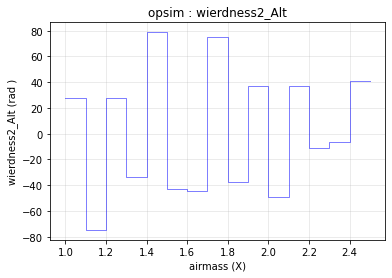

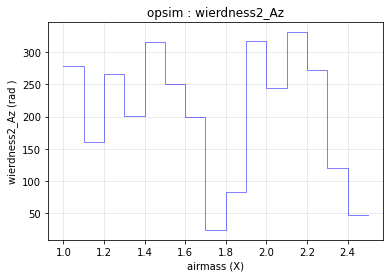

In [23]:
slicer = maf.OneDSlicer(sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.1)
metric = MyWierdMetric2()
bundle = maf.MetricBundle(metric, slicer, "")
bgroup = maf.MetricBundleGroup([bundle], opsim_db_fname, outDir=output_dir)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

With the addition of reduce methods (those beginning in `reduce`) that transform our custom object into scalars, plots that use scalars now appear. 

Full metric bundles corresponding to these new "reduced metrics" are present in the metric bundle group, and this provides access values themselves.

In [24]:
bgroup.bundleDict.keys()

dict_keys(['opsim_wierdness2_ONED', 'wierdness2_Alt', 'wierdness2_Az'])

In [25]:
bgroup.bundleDict['wierdness2_Alt'].metricValues

masked_array(data=[27.748651376649068, -74.70867834287853,
                   27.359201708949715, -33.87913814643979,
                   78.8074424215729, -42.895141726013975,
                   -44.79790322094041, 75.43248619598359,
                   -37.41140535523082, 37.38457167534076,
                   -48.83854078199618, 36.76355230946422,
                   -11.067989482412692, -6.130788118282641,
                   40.656425423425524],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=0.0)

## 10. Metrics for use with spatial slicers

If the metric can get all the data it needs from the columns that can be passed in as part of the `dataSlice`, nothing special is required to use them to make a map on the sky.

Some metrics require data on the coordinates of the slice point, and only make sense when appied to a slicer than slices based on position in the sky.
MAF's `rubin_sim.maf.metrics.HealpixSlicer` is an example of such a slicer.
The `HealpixSlicer` creates `slicePoint`s with keys that provide coordinate information on the slice:
- `sid`, the `healpix` id
- `ra`, the RA in radians
- `dec`, the declination in radians
- `nside`, the nside of the healpix pixelization

When combined with values that can be passed in with the `dataSlice`, these values should provide the data needed to, for example, determine which part of the focal plane falls in the slice, or the area covered by the slice.

The `maf.ExgalM5` metric is one example of a metric that requires such coordinate information for from the slicers it can be used with:

In [26]:
%psource maf.ExgalM5

This metric demonstrates an additional feature of MAF metrics: the use of maps.
In this case, calculation of the metric requires a dust map, and this is specified in the call to the initializer of the parent class (`super().__init__...`).
When the metric is evaluated, the dictionary supplied in the `slicePoint` argument to `run` includes not only those generated by the slicer, but also `ebv`, the extinction from the dust map.

There are other MAF `map`s available as well, each of which supplements the `slicePoint` dictionary with different values:

In [27]:
maf.BaseMap.help(doc=True)

----  BaseMap  ----
 
 added to SlicePoint:  newkey
----  DustMap  ----

    Compute the E(B-V) for each point in a given spatial distribution of slicePoints.

    Primarily, this calls EBVhp to read a healpix map of E(B-V) values over the sky, then
    assigns ebv values to each slicePoint. If the slicer is a healpix slicer, this is trivial.

    Parameters
    ----------
    interp : `bool`, opt
        Interpolate the dust map at each slicePoint (True) or just use the nearest value (False).
        Default is False.
    nside : `int`, opt
        Default nside value to read the dust map from disk. Primarily useful if the slicer is not
        a healpix slicer.
        Default 128.
    mapPath : `str`, opt
        Define a path to the directory holding the dust map files.
        Default None, which uses RUBIN_SIM_DATA_DIR.
    
 added to SlicePoint:  ebv
----  DustMap3D  ----
The DustMap3D provides a `~rubin_sim.maf.map` to hold 3d EBV data.

    Adds the following keys to the slice

## 11. What columns and stackers can I use?

You can get a list of columns available in an `opsim` output database by looking at the sqlite database output itself, or looking up the relevant documentation on the `rubin_sim` documentation pages (https://rubin-sim.lsst.io/rs_scheduler/output_schema.html).

This code will print a list of available stackers, and what columns they supply:

In [28]:
import pprint

pprint.pprint({k: v.colsAdded for k, v in maf.BaseStacker.registry.items()})

{'AppMagNullStacker': ['appMag'],
 'AppMagStacker': ['appMag'],
 'BaseDitherStacker': [],
 'BaseMoStacker': [],
 'CoaddStacker': ['coadd'],
 'CometAppMagStacker': ['appMag'],
 'DcrStacker': ['ra_dcr_amp', 'dec_dcr_amp'],
 'EclStacker': ['ecLat', 'ecLon'],
 'EclipticStacker': ['eclipLat', 'eclipLon'],
 'FiveSigmaStacker': ['m5_simsUtils'],
 'GalacticStacker': ['gall', 'galb'],
 'HexDitherFieldPerNightStacker': ['hexDitherFieldPerNightRa',
                                   'hexDitherFieldPerNightDec'],
 'HexDitherFieldPerVisitStacker': ['hexDitherFieldPerVisitRa',
                                   'hexDitherFieldPerVisitDec'],
 'HexDitherPerNightStacker': ['hexDitherPerNightRa', 'hexDitherPerNightDec'],
 'HourAngleStacker': ['HA'],
 'M5OptimalStacker': ['m5Optimal'],
 'MoMagStacker': ['appMag', 'SNR', 'vis'],
 'NEODistStacker': ['MaxGeoDist', 'NEOHelioX', 'NEOHelioY'],
 'NFollowStacker': ['nObservatories'],
 'NormAirmassStacker': ['normairmass'],
 'ParallacticAngleStacker': ['PA'],
 'P